# Basics of Bayesian inference

Concepts: Prior, likelihood, evidence, posterior

- Two simple examples
- Coding it up ourselves in Python

## Example 1: Medical diagnosis

Guido wakes up with spots all over his face. What is the probability he has smallpox?

From public medical statistics we know that 90% of people with smallpox have spots, whereas 80% of people with chickenpox have spots:

$$p(\textrm{spots | smallpox}) = 0.9$$

$$p(\textrm{spots | chickenpox}) = 0.8$$

We also know that 125 people in every 1000 have spots and that 1 in every million people have smallpox.

## Bayes' theorem

Let $D$ be the data and $M$ be a certain model for the data (or hypothesis).

Bayes' theorem can be derived very simply from the laws of probability. It states:

$$
p(M | D) = p(M) \times \frac{p(D|M)}{p(D)}
$$

$$
\textrm{posterior} = \textrm{prior } \times \frac{\textrm{likelihood}}{\textrm{ evidence}}
$$

### Likelihood

The "likelihood of smallpox" is the conditional probability of spots (the data) given that the patient has smallpox (the model / diagnosis).

In [78]:
def likelihood(data, model):
    """
    Conditional probability of the data ('spots' / 'no spots') given the model
    ('smallpox' / 'not smallpox').
    """
    if data == 'spots':
        return {'smallpox': 0.9, 'not smallpox': 0.05}[model]
    else:
        return {'smallpox': 0.1, 'not smallpox': 0.95}[model]

In [79]:
likelihood('spots', 'smallpox')

0.9

### Prior

The "prior" reflects our "prior knowledge" expressed as a background level of belief. What is the background prevalence of smallpox in the general population?

In [80]:
def prior(model):
    return {'smallpox': 1e-6, 'not smallpox': 1 - 1e-6}.get(model)

The evidence and posterior have definitions in terms of each other (but for the normalization flag).

In [81]:
def evidence(data):
    """
    The proportion of people in the general population who have spots or no spots
    """
    return (posterior('smallpox', data, normalize=False) +
            posterior('not smallpox', data, normalize=False))

In [82]:
def posterior(model, data, normalize=True):
    """
    Posterior probability of the model ('smallpox / 'not smallpox')
    given the data ('spots' / 'no spots')
    """
    numerator = likelihood(data, model) * prior(model)
    if not normalize:
        return numerator
    else:
        return numerator / evidence(data)

In [83]:
evidence('spots')

0.05000085

In [84]:
posterior('smallpox', 'spots', normalize=True)

1.799969400520191e-05

In [85]:
posterior('smallpox', 'no spots', normalize=True)

1.052632520776466e-07

In [86]:
posterior('not smallpox', 'spots', normalize=True)

0.9999820003059948

In [87]:
posterior('not smallpox', 'no spots', normalize=True)

0.999999894736748

### Exercise 1: 
Check that substituting this for $x$ above correctly leads to the sum of both model probabilities (given spots and given no spots) to be 1

In [44]:
# See solutions/check_normalized.ipy

### Exercise 2: how much more likely is Guido to have chickenpox than smallpox?

We learn from public medical records that 80% of people with chickenpox have spots and that 1 in every 10,000 people have chickenpox. (As before, 1 in every 20 people have spots.)

Repeat the above steps for chickenpox.

### Solution

In [88]:
# Solution:
def prior(model):
    return {'chickenpox': 1e-4, 'not chickenpox': 1 - 1e-4}.get(model)

def posterior(model, data, normalize=True):
    """
    Posterior probability of the model ('smallpox / 'not smallpox')
    given the data ('spots' / 'no spots')
    """
    numerator = likelihood(data, model) * prior(model)
    if not normalize:
        return numerator
    else:
        return numerator / evidence(data)

In [89]:
import sympy
x = sympy.symbols('x')   

def likelihood(data, model):
    """
    Conditional probability of the data ('spots' / 'no spots') given the model ('chickenpox' / 'not chickenpox').
    """
    if data == 'spots':
        return {'chickenpox': 0.8, 'not chickenpox': x}[model]
    else:
        # no spots
        return {'chickenpox': 0.2, 'not chickenpox': 1 - x}[model]
    
def evidence(data):
    """
    The proportion of people in the general population who have spots or no spots
    """
    return (posterior('chickenpox', data, normalize=False) +
            posterior('not chickenpox', data, normalize=False))

In [90]:
conditional_sum = (posterior('chickenpox', 'spots', normalize=True) +
                   posterior('not chickenpox', 'spots', normalize=True))

### Question: does it matter for normalization what the value of $x$ is?

Try a few values using `conditional_sum.subs(x, value)`.

In [91]:
# E.g.
conditional_sum.subs(x, 0.3)

1.00000000000000

### Answer to the exercise question

Here is the probability that a spotty Guido has chickenpox:

In [92]:
p_chickenpox_given_spots = posterior('chickenpox', 'spots')
p_chickenpox_given_spots.subs(x, 0.05)

0.00159760359460809

### Quick question: 

Suppose $x$ (the probability of spots without chickenpox) were much higher, like among teenagers. How would this affect the posterior probability of chickenpox?

In [101]:
# Try it out ...

### Question: which of the weak syllogisms for plausible inference does this relate to?

## Model comparison

If we want to compare two models or hypotheses for the given data, we can compare the ratio of posterior probabilities (also known as posterior odds) between the two hypotheses.

Here, with hypotheses $\theta_c$ (Guido has chickenpox) and $\theta_s$ (Guido has smallpox):

$$
R_{\textrm{posterior}} = \frac{p(\theta_c | x)}{p(\theta_s | x)}
$$

If we apply Bayes' rule, the marginal likelihoods cancel, so:

$$
R_\textrm{posterior} = \frac{p(x | \theta_c)}{p(x | \theta_s)} \frac{p(\theta_c)}{p(\theta_s)}
$$

$$
\textrm{posterior odds} = \textrm{Bayes factor} \times \textrm{prior odds}
$$

### Bayesian hypothesis testing

We can do Bayesian hypothesis testing by calculating the Bayes factor, prior odds, and posterior odds for the hypothesis of chickenpox vs smallpox.

**Home-play exercise**

## Example 2: flipping coins

**Question:** How would you decide how unfair a coin is, based on just two coin flips?

Define $p(\theta)$ as the probability that the coin has a given bias $\theta$. Define bias of 1 to be *always heads* and a bias of 0 to be *always tails*.

Start with the likelihood, $p(x | \theta)$

In [50]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
def likelihood(data, theta):
    """
    Conditional probability of the data (x heads out of N coin tosses),
    given the bias theta of the model (potentially biased).
    """
    x, N = data
    return scipy.stats.binom(N, theta).pmf(x)

In [96]:
N = 15

In [97]:
likelihood([5, 15], 0.3)

0.20613038097752118

Now we will choose a prior. Let's go with a Beta prior. (Look up "conjugate priors".)

In [98]:
def prior(theta, α, β):
    return scipy.stats.beta(α, β).pdf(theta)

In [99]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)

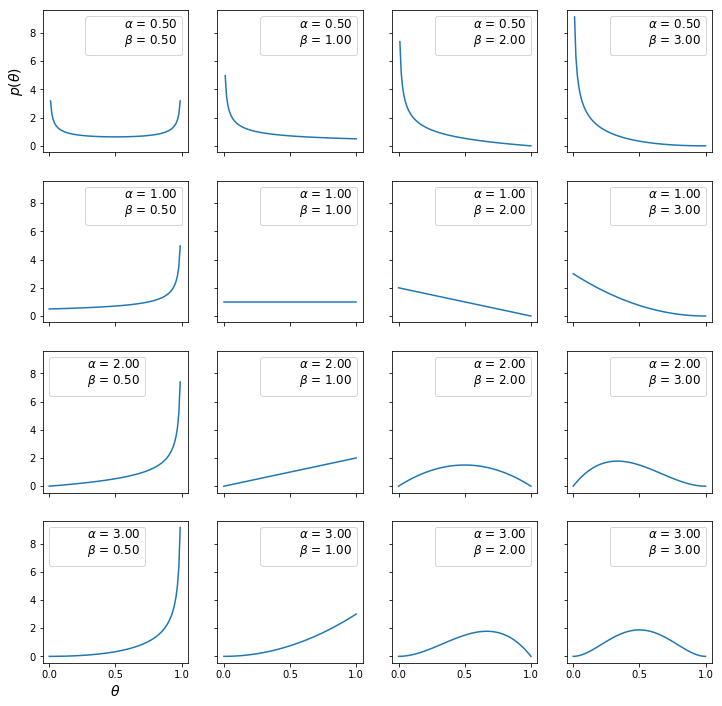

In [100]:
%run plot_priors.ipy

### Question: Which do you think best matches the belief that the coin is:
1. more likely to be fair than biased
1. just as likely to be biased as fair
1. probably biased towards heads

### Solution

In [23]:
beta_params = ((2, 2), (1, 1), (1, 0.5))

## Now, how to incorporate the data?

### Evidence / marginal posterior

The evidence for the data is now $$p(\textrm{data}) = \int_{0}^1 d\theta \space p(\textrm{data | }\theta) p(\theta)$$

In [60]:
from scipy.integrate import quad

def evidence(data):
    def lik(theta):
        return likelihood(data, theta)
    def post(theta):
        return lik(theta) * prior(theta, α, β)
    evidence, abserr = quad(post, 0, 1, )
    return evidence

For now, we will just fix these: ("just as likely biased as fair"):

In [59]:
(α, β) = (1, 1)

In [58]:
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta = np.linspace(0, 1)

In [63]:
def lik(theta):
    return likelihood((data[-1], trials[-1]), theta)
lik(theta)[:10]

array([  0.00000000e+00,   4.33764125e-43,   1.42583319e-29,
         4.50574362e-22,   4.75557907e-17,   2.15466932e-13,
         1.30523859e-10,   1.93544556e-08,   1.00674662e-06,
         2.31423249e-05])

In [64]:
evidence((data[-1], trials[-1]))

0.006622516556292279

In [67]:
def posterior(model, data, normalize=True):
    """
    Posterior probability of the model given the data
    """
    numerator = likelihood(data, model) * prior(model, α, β)
    if not normalize:
        return numerator
    else:
        return numerator / evidence(data)

In [68]:
posterior(0.4, (15, 50))

2.1188802963271978

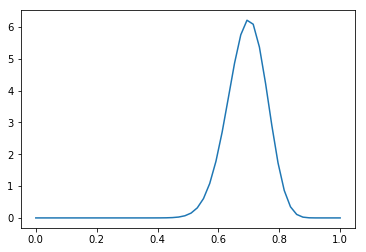

In [69]:
plt.plot(theta, [posterior(t, (35, 50)) for t in theta])

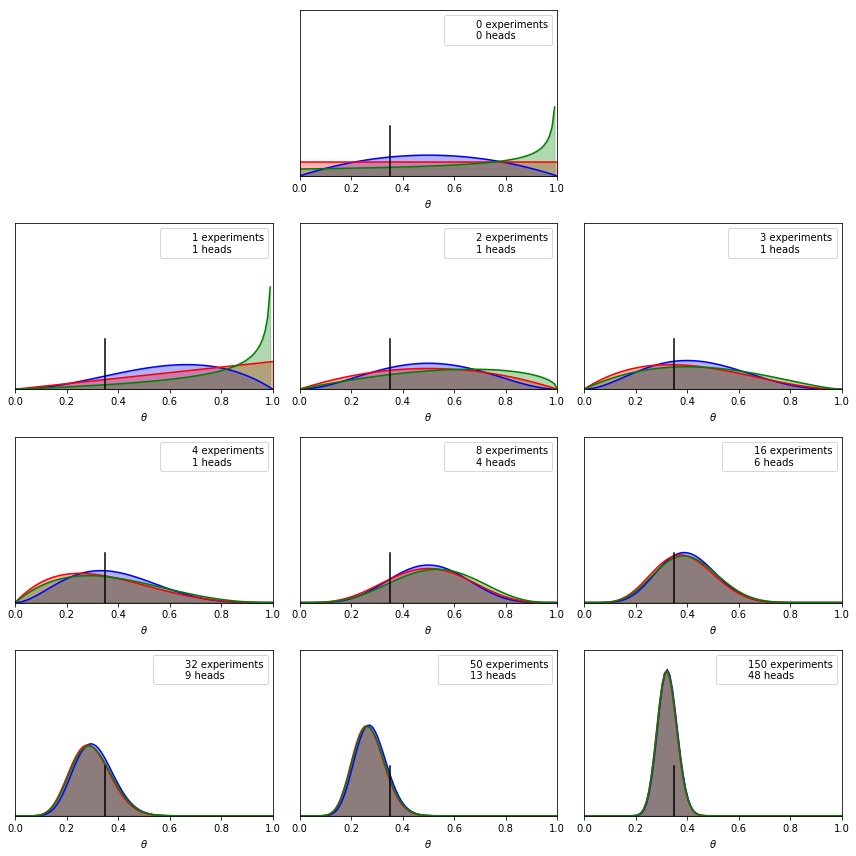

In [70]:
%run show_posteriors_dice.ipy

### Result

The result of Bayesian inference is a posterior **probability distribution**. This gives us more information than just the single most probable model or hypothesis; it also gives us information about the error associated with each choice.

### Credible intervals

A convenient way to summarize the spread of the posterior distribution is with a "credible interval" of "Highest Posterior Density (HPD). This is the shortest interval containing a given portion of the probability density (such as 50%, 95% or 98%).

### Challenge exercise:
Implement this function:
```
def hpd(posterior, alpha=0.05):
    """
    A (1 - \alpha) credible interval
    
    Parameters
    ----------
    posterior : function
        A posterior probability density function (normalized)
    
    alpha : float
        A significance level (of sorts)
        
    Returns
    -------
        A tuple (lower, upper) giving the lower and upper bounds for
        the (1 - α) credible interval
    """
    ...
```
You might try using `scipy.integrate.quad`.